This script contains the functions needed to create gradients from subject data. Gradients are calculated, aligned to other gradients, written to a pscalar file in scratch, and plotted.

In [1]:
import pandas as pd
import os
import nibabel as nib
from brainspace.gradient import GradientMaps
import pandas as pd
import numpy as np
from pathlib import Path

Loading in the SPINS resting state data, a file containing ROIs with their associated networks, and the margulies 
gradients. ROIs are added to the SPINS gradients file and the network file is loaded, so the two can be merged.

In [2]:
pconnGrad = '/KIMEL/tigrlab/scratch/edickie/HCP_S1200_dconns/group-HCPS1200_atlas-GlasserTian_desc-subcorticalS2_conn.pconn.nii'
networks = '../networks.txt'
margulies = '../tpl-fsLR_den-32k_atlas-Glasser2016Tian2019S2_desc-margulies2016_gradients.pscalar.nii'

Reading in the file containing the networks for each ROI and merging the gradient file with the list of ROIs to classify netowrks for each gradient file

In [3]:
network_file = pd.read_csv(networks, sep="\t") 
networks_df = pd.DataFrame(data = network_file)
#grad_roi_df = pd.concat([grad_df, ROIs_list], axis =1)

Folders are created in scratch to hold each subject and its data, as well as the concatenated file

In [4]:
## read correlation matrix from the folder
subj_fold = "/KIMEL/tigrlab/scratch/jcyu/spin_gradients/data/spins_RS_2mm_GSR_GlasserTian_combat_cor/"
subj_cor_list = list()
subj_cor_dict = dict()
for subj_path in sorted(os.listdir(subj_fold))[1:]:
#     print(subj_path)
    if (subj_path.startswith("SPN")):
        full_path = os.path.join(subj_fold, subj_path)
    #    print(full_path)
        subj_file = open(full_path)
        subj_csv = pd.read_csv(full_path, sep=" ") 
        subj_df = pd.DataFrame(data = subj_csv)
    #    print(subj_df)
        subj_cor_list += [subj_df]
        subj_cor_dict[subj_path.rstrip('.txt')] = subj_df
    
# subj_matrix_dict
#subj_cor_dict["SPN01_CMH_0001"]
#subj_cor_dict.keys()

# pandas.to_csv(new_dict, sep=" ")

In [5]:
# save subject list
RS_subjects_list = list(subj_cor_dict.keys())

calc_aligned_gradients is used to align the gradients that were created to a template. All the subject gradients are aligned 
with the HCP template, which in turn is aligned to the Margulies gradients from his 2016 paper.

In [23]:
from scipy.spatial import procrustes
import nibabel as nib
from brainspace.gradient import GradientMaps
import pandas as pd
import numpy as np

def calc_aligned_gradient(input_timeseries, template_gradients, kernel = 'cosine', alignment = 'procrustes'):
    '''Align a set of gradients to a template series of gradients using procrustes, returns as dataframe

    Loads GradientMaps, and makes same number of gradients as in the template
    Fits the desired gradients to the reference template
    Converts to pandas dataframe with labelled columns

    Parameters
    ----------
    input_timeseries:   ndarray or list of arrays, shape = (n_ROIs, n_timepoints))
    template_gradients: ndarray or list of arrays, shape =  (n_rois, n_gradients)


    Returns
    -------
    grad_df_aligned
        An array of values, rows x columns is ROIs x n number of gradients 

    ''' 
    # load GradientMaps
    gm = GradientMaps(n_components=template_gradients.shape[1], random_state=0, alignment = alignment, kernel=kernel)
    # assert that the number of gradients requested does not exceed the regions of interest 
    # create the gradient as a matrix
    gm.fit(input_timeseries, reference = template_gradients)
    gradient = gm.aligned_
    # convert gradient to a pandas dataframe
    grad_df_aligned = pd.DataFrame(data = gradient, 
    columns=[f'grad{num + 1}' for num in range(gm.aligned_.shape[1])])
    return grad_df_aligned


Margulies gradients are loaded, transposed, and selected for the first 10 to be aligned with the HCP data.

In [13]:
margulies_load = nib.load(margulies)    # margulies gradients need to be transposed to be in correct format
margulies_matrix = margulies_load.get_fdata().T
margulies_df = pd.DataFrame(data = margulies_matrix, 
    columns=[f'grad{num + 1}' for num in range(margulies_matrix.shape[1])])
margulies_grad_df = margulies_df.iloc[:, 0:10]

In [24]:
# test calc_algined_gradient function
grad_df_aligned = calc_aligned_gradient(subj_cor_list[1].values, margulies_grad_df.values)

Aligning every single file to the SPINS gradients that were previously aligned to the margulies gradients. Concatenating EA and rest files together

In [25]:
aligned_RS_gradients = list()            # empty list to hold the procrustes algined emp/rest/concatenated gradients 

for i in range(len(subj_cor_list)):             # creates aligned emp/rest/concatenated gradients for all subjects
    aligned = calc_aligned_gradient(subj_cor_list[i].values, grad_df_aligned.values)
    aligned_RS_gradients.append(aligned) 

# len(aligned_RS_gradients)

write_df_column_to_pscalar_nib function takes the gradients that were created and converts them to a pscalar file
which allows for the gradient to be plotted.

In [31]:
from pathlib import Path

def write_df_column_to_pscalar_nib(df, pscalar_template, 
        to_filename = None, columns = None, labelname_column = None):
    ''' write a column from a pandas dataframe to pscalar file in nibabel 
     Parameters
    ----------
    df: pandas DataFrame
        Pandas dataframe containing data to write to file (with rows as parcels)
    
    pscalar_template: nibabel.Cifti2Image or filepath
        A pscalar.nii or pterseries.nii file or image to read the parcel axis from
    
    to_filename: str or path
        (optional) path (with extension .pscalar.nii) to write the output to
    columns: str or list
        (optional) list of columns to select for the pscalar image
    labelnames_column: str
        (optional) name of column that contains labelnames that should match the pscalar parcel names
        If this is given than data will be merged/aligned with the parcel axis before writing file.
    
    Returns
    -------
    pscalar_img: nibabel.Cifti2Image
        nibabel image of the pscalar output
        '''
           ## read the parcel axis from a template file
    if isinstance(pscalar_template, (str, Path)):
        pscalar_template = nib.load(pscalar_template)
    template_axis = pscalar_template.header.get_index_map(1)
    axis1_parcels = nib.cifti2.cifti2_axes.ParcelsAxis.from_index_mapping(template_axis)
    assert (isinstance(axis1_parcels, nib.cifti2.cifti2_axes.ParcelsAxis)), "Did not creat parcel axis"

    if labelname_column:
        axis_df = pd.DataFrame({'labelnames': axis1_parcels.name})
        df = df.merge(axis_df, 
            left_on = labelname_column, right_on = 'labelnames', how = 'right')
    
    ## grab columns if they exist
    if columns:
        df = df[columns]

    # grab the data column(s) and resphape them to the shape for pscalar 
    ## note that the dataobj shape should be (n_map, n_parcels)
    data_vals = df.transpose().values
    if len(data_vals.shape) == 1:
        data_vals = np.reshape(data_vals, (1,data_vals.shape[0]))
    
    ## assert that the number of parcels matches the length of the data array
    assert (axis1_parcels.size == len(df.index)), 'The number of parcels does not match the number of rows'

    ## create a scalar axis with names inlcuding the column names
    axis0_scalars = nib.cifti2.cifti2_axes.ScalarAxis(name = df.columns)
    
    ## combine all the bits together
    new_header = nib.Cifti2Header.from_axes((axis0_scalars, axis1_parcels))
    pscalar_img = nib.Cifti2Image(
        dataobj=data_vals, header = new_header)
    if to_filename:
        nib.cifti2.save(
            img = pscalar_img,filename=to_filename)

    return(pscalar_img)

Writing every aligned gradient to a pscalar file, and in turn writing those to their subject folders in scratch. 

In [35]:
len(RS_subjects_list)

'SPN01_ZHP_0077'

In [36]:
aligned_RS_pscalars = list()       #writes every rest gradient to a pscalar

for i in range (len(RS_subjects_list)):

    aligned_RS_pscalar = write_df_column_to_pscalar_nib(aligned_RS_gradients[i], pconnGrad, to_filename= f'/KIMEL/tigrlab/scratch/jcyu/spin_gradients/data/spins_RS_gradients/{RS_subjects_list[i]}_GSR_rest_atlas-glassertian_gradients.pscalar.nii' )
    aligned_RS_pscalars.append(aligned_RS_pscalar)

Creating mutiple lists which will become columns in  large dataframe files to hold every gradient. Including the subject IDs, the ROI that corresponds to each point in the gradient, and whether the gradient is for rest or EA.

In [37]:
subject_list= list()               #empty list for the large concatenated file of all information
subject_list_df = list()           #creates one column dataframe to be horizontally concat with file

for i in range(len(RS_subjects_list)):
    subject=[RS_subjects_list[i]]*392
    subject_list.append(subject)

    subject_list_dfs=pd.DataFrame(subject_list[i],
                                columns=['Subject'])
    subject_list_df.append(subject_list_dfs)
    
ROIs = aligned_RS_pscalar.header.get_axis(1).name         #single column grad of the ROI for each value in the concat grad

ROIs_list = pd.DataFrame(ROIs, 
                         columns=['ROI']) 

RS_list = ['RS'] * 392                  #specifies whether value in large gradient is rest or emp

RS_list_df=pd.DataFrame(RS_list,
                       columns=['Task'])

Merging the network file and the HCP gradients containing the ROI names to have network values for each ROI. Making
it into a df as well to be added to the all_concat file below.

In [65]:
merge_networks = pd.merge(ROIs_list, networks_df, how = "left", left_on = "ROI", right_on = "GLASSERLABELNAME")
merge_networks['network1'] = merge_networks['NETWORK'].replace(np.nan, "Subcortical")
# merge_networks
networks_list = merge_networks['network1'].to_numpy()
# networks_list
networks_list_df = pd.DataFrame(networks_list, 
                         columns=['Network'])
#path = '/scratch/a/arisvoin/lbassman/spins_gradients/merge_networks'    #writes dataframe to csv in scratch 
#merge_networks.to_csv(path_or_buf=path)

,Network
0,Subcortical
1,Subcortical
2,Subcortical
3,Subcortical
4,Subcortical
...,...
387,Default
388,Default
389,Cingulo-Opercular
390,Cingulo-Opercular


Creating the all_concat master file, including columns created above, and all the EA and rest dataframes. Tasks are concatenated first horizontally, and then the two are concatenated together vertically. One file is created for each specification, with and without GSR, and the full and shortened versions of the EA task. These files are written to scratch.

In [66]:
pd.concat([aligned_RS_gradients[1].iloc[:,0:3],ROIs_list,networks_list_df,RS_list_df,subject_list_df[1]],axis=1)

,grad1,grad2,grad3,ROI,Network,Task,Subject
0,-0.177619,0.652877,-0.876071,aHIP-rh,Subcortical,RS,SPN01_CMH_0002
1,0.426126,0.527055,-0.643835,pHIP-rh,Subcortical,RS,SPN01_CMH_0002
2,0.254581,0.270618,-0.681889,lAMY-rh,Subcortical,RS,SPN01_CMH_0002
3,0.262546,0.108983,-0.413689,mAMY-rh,Subcortical,RS,SPN01_CMH_0002
4,-0.453635,-0.423248,-0.332516,THA-DP-rh,Subcortical,RS,SPN01_CMH_0002
...,...,...,...,...,...,...,...
387,0.773658,-0.330894,-0.750315,L_STSva_ROI,Default,RS,SPN01_CMH_0002
388,0.707382,-0.132463,-0.576044,L_TE1m_ROI,Default,RS,SPN01_CMH_0002
389,-0.106934,-0.585310,0.299705,L_PI_ROI,Cingulo-Opercular,RS,SPN01_CMH_0002
390,0.417153,-0.401107,0.842205,L_a32pr_ROI,Cingulo-Opercular,RS,SPN01_CMH_0002


In [67]:
RS_concatenated = list()

for i in range(len(subj_cor_list)):
    RS_concat=pd.concat([aligned_RS_gradients[i].iloc[:,0:3],ROIs_list,networks_list_df,subject_list_df[i]],axis=1)
    RS_concatenated.append(RS_concat)
    
RS_concat = pd.concat(RS_concatenated)

RS_concat['Site'] = [s[4:7] for s in RS_concat['Subject']]

In [69]:
RS_concat.to_csv('/KIMEL/tigrlab/scratch/jcyu/spin_gradients/data/spins_gsr_RS_gradients.csv')

Creating a colour map based on values provided in the network file. Will be implemented into scatterplots.

In [70]:
network_colours=([0,0,0,255], #subcortical, black
                 [0,0,1,1], #visual1, blue
                 [100/255,0,1,1], #visual2, lighter blue
                 [0,1,1,1], #somatomotor, cyan
                 [153/255,0,153/255,1], #cingulo-operator, purple
                 [0,1,0,1], #dorsal attention, bright green
                 [0,155/255,155/255,1], #language, azure blue
                 [1,0,0,1], #frontoparietal, red
                 [250/255,62/255,251/255,1], #auditory, pink/purple
                 [1,1,0,1], # default 9, yellow
                 [65/255,125/255,0,168/255], #orbito affective, green
                 [1,157/255,0,1], # ventral multimodal, orange
                 [177/255,89/255,40/255,1] # posterial multimodal, orange/brown
                )

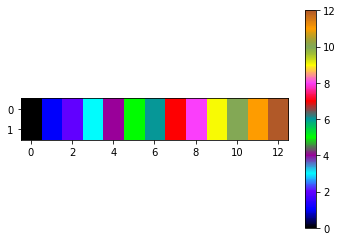

In [72]:
import matplotlib.pyplot as plt

from matplotlib.colors import LinearSegmentedColormap

my_cmap = LinearSegmentedColormap.from_list('network_basic', network_colours)

my_x_data = [0,1,2,3,4,5,6,7,8,9,10,11,12]
my_y_data = [0,1,2,3,4,5,6,7,8,9,10,11,12]
my_data = (my_x_data,my_y_data)
plt.imshow(my_data, cmap=my_cmap)
plt.colorbar()
#plt.legend(labels='Visual1','Visual2','Somatomotor','Cingulo-Operator','Dorsal-Attention','Language','FrontoParietal',
 #          'Auditory','Default9','Orbito-Affective','Ventral-Multimodal',"Posterior-Multimodal")

